In [103]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [7]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

# How well do moments enforce model structure?

While testing it was found that for detecting interaction moment constraints + CME constraints produced identical results to simply moment constraints with dummy variables:

\begin{align*}
    \sum_{x_{1} = 0}^{max_1} x p_{1}(x) &\in \mathbb{E}[X_{1}] \text{ CI } &\iff y &\in \mathbb{E}[X_{1}] \text{ CI } \\
    \sum_{x_{2} = 0}^{max_2} x p_{2}(x) &\in \mathbb{E}[X_{2}] \text{ CI } &z &\in \mathbb{E}[X_{2}] \text{ CI } \\
    \left(\sum_{x_{1} = 0}^{max_1} x p_{1}(x) \right) \left(\sum_{x_{2} = 0}^{max_2} x p_{2}(x) \right) &\in \mathbb{E}[X_{1}X_{2}] \text{ CI }  &y * z &\in \mathbb{E}[X_{1}X_{2}] \text{ CI }\\

    \textbf{ + CME constraints}
    
\end{align*}

Since the moment constraints did not give enough information about the probabilities for the CME to enforce the model structure e.g. taking non-poisson data from an independent telegraph model and inputting the moments together with a birth-death CME was always* feasible

In [174]:
def optimize_moment(M, k, delta, silent=True, printing=True, time_limit=300, var=False):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
            E_x = model.addVar(vtype=GRB.CONTINUOUS, name="E_x")
            if var: E_x_2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x_2")

            # constraints

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # moments
            expr_E_x = gp.quicksum(p * np.arange(M + 1))
            if var: expr_E_x_2 = gp.quicksum(p * np.arange(M + 1)**2)
            model.addConstr(E_x == expr_E_x, name="E_x_equality")
            if var: model.addConstr(E_x_2 == expr_E_x_2, name="E_x_2_equality")
            model.addConstr(E_x <= k + delta, name="E_x_UB")
            model.addConstr(E_x >= k - delta, name="E_x_LB")
            if var: model.addConstr(E_x_2 <= k + k**2 + delta, name="E_x_2_UB")
            if var: model.addConstr(E_x_2 >= k + k**2 - delta, name="E_x_2_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]
            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

In [175]:
def optimize_probability(M, k, delta, silent=True, printing=True, time_limit=300):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # constraints

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # probabilities
            probs = scipy.stats.poisson.pmf(np.arange(M + 1), k)
            model.addConstr(p <= probs + delta, name="p_UB")
            model.addConstr(p >= probs - delta, name="p_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]
            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

In [176]:
solution = optimize_moment(10, 2, 0.1, silent=True, var=True)

k_tx in (1.9801020198650077, 2.2113706420060817), status OPTIMAL, OPTIMAL


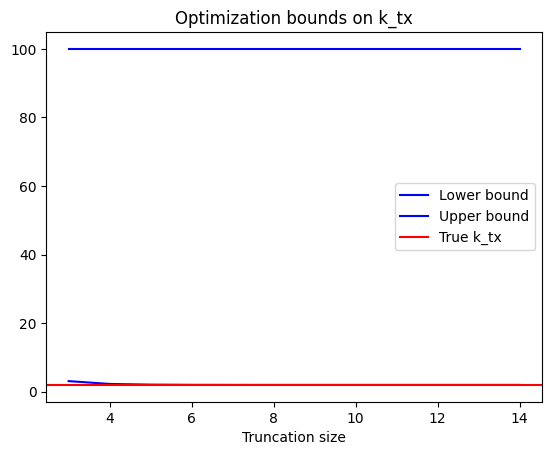

In [177]:
delta = 0.01
k = 2
m_list = [m for m in range(2, 15)]
lbs = []
ubs = []
for m in m_list:
    solution = optimize_moment(m, k, delta, silent=True, printing=False, var=False)
    lbs.append(solution['min'])
    ubs.append(solution['max'])
plt.title("Optimization bounds on k_tx")
plt.xlabel("Truncation size")
plt.plot(m_list, lbs, color="blue", label="Lower bound")
plt.plot(m_list, ubs, color="blue", label="Upper bound")
plt.axhline(k, color="red", label="True k_tx")
plt.legend()

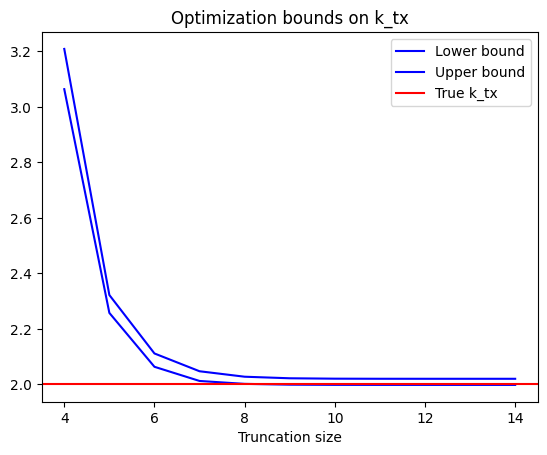

In [178]:
delta = 0.01
k = 2
m_list = [m for m in range(2, 15)]
lbs = []
ubs = []
for m in m_list:
    solution = optimize_moment(m, k, delta, silent=True, printing=False, var=True)
    lbs.append(solution['min'])
    ubs.append(solution['max'])
plt.title("Optimization bounds on k_tx")
plt.xlabel("Truncation size")
plt.plot(m_list, lbs, color="blue", label="Lower bound")
plt.plot(m_list, ubs, color="blue", label="Upper bound")
plt.axhline(k, color="red", label="True k_tx")
plt.legend()

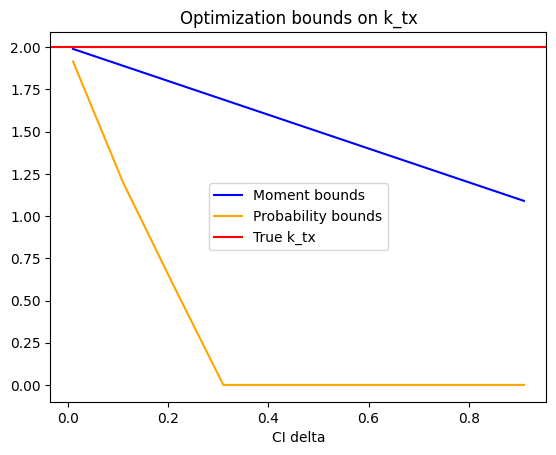

In [190]:
deltas = [0.01 + d/10 for d in range(10)]
k = 2
m = 20
lbs_moment = []
ubs_moment = []
lbs_probs = []
ubs_probs = []
for delta in deltas:
    solution_moment = optimize_moment(m, k, delta, silent=True, printing=False, var=False)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    solution_probs = optimize_probability(m, k, delta, silent=True, printing=False)
    lbs_probs.append(solution_probs['min'])
    ubs_probs.append(solution_probs['max'])
plt.title("Optimization bounds on k_tx")
plt.xlabel("CI delta")
plt.plot(deltas, lbs_moment, color="blue", label="Moment bounds")
#plt.plot(deltas, ubs_moment, color="blue")
plt.plot(deltas, lbs_probs, color="orange", label="Probability bounds")
#plt.plot(deltas, ubs_probs, color="orange")
plt.axhline(k, color="red", label="True k_tx")
plt.legend()

BUT unfair comparison? as confidence interval width will be related to value, and moments are typically larger values than probabilities (which are in [0, 1] and often small)

Need to find typical ranges of CI width to assess